In [ ]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 62.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitli

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#1. Training and Evaluating Unimodal numerical time-series approach using Transformer and GRU.

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
torch.use_deterministic_algorithms(False)


# Parameters
sequence_length = 3  # 3 consecutive timesteps
numerical_features = ["Ice Coverage (%)", "Retreat Area (Since 1979) (%)"]
target_column = "Retreat Area (Yearly) (%)"
csv_file_path = "/content/drive/MyDrive/dip_project/ice_extent_full_dataset.csv"

# Load dataset
df = pd.read_csv(csv_file_path)
df = df.sort_values(["Year", "Image"])

def create_sequences(df, sequence_length, features, target_column):
    sequences = []
    targets = []
    years = []
    for i in range(len(df) - sequence_length + 1):
        seq = df.iloc[i:i+sequence_length][features].values
        target = df.iloc[i+sequence_length - 1][target_column]
        year = df.iloc[i+sequence_length - 1]["Year"]
        sequences.append(seq)
        targets.append(target)
        years.append(year)
    return np.array(sequences), np.array(targets), np.array(years)

# time series sequences
sequences, targets, years = create_sequences(df, sequence_length, numerical_features, target_column)
n = len(sequences)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

train_seqs = sequences[:train_end]
val_seqs = sequences[train_end:val_end]
test_seqs = sequences[val_end:]

y_train = targets[:train_end]
y_val = targets[train_end:val_end]
y_test = targets[val_end:]
year_train = years[:train_end]
year_val = years[train_end:val_end]
year_test = years[val_end:]

# Normalize numerical features using StandardScaler
scaler_num = StandardScaler()
train_seqs_flat = train_seqs.reshape(-1, len(numerical_features))
scaler_num.fit(train_seqs_flat)

train_seqs = scaler_num.transform(train_seqs_flat).reshape(train_seqs.shape)
val_seqs = scaler_num.transform(val_seqs.reshape(-1, len(numerical_features))).reshape(val_seqs.shape)
test_seqs = scaler_num.transform(test_seqs.reshape(-1, len(numerical_features))).reshape(test_seqs.shape)

scaler_target = StandardScaler()
y_train = scaler_target.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val = scaler_target.transform(y_val.reshape(-1, 1)).flatten()
y_test = scaler_target.transform(y_test.reshape(-1, 1)).flatten()

# Convert data into PyTorch tensors
X_train = torch.tensor(train_seqs, dtype=torch.float32)
X_val = torch.tensor(val_seqs, dtype=torch.float32)
X_test = torch.tensor(test_seqs, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create Datasets and DataLoaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Train sequences: {len(train_dataset)}, Val sequences: {len(val_dataset)}, Test sequences: {len(test_dataset)}")

# Unimodal Numerical Model using Transformer and GRU


class NumericalTransformerGRUModel(pl.LightningModule):
    def __init__(self, num_feature_dim, d_model=128, transformer_layers=1,
                 gru_hidden_size=128, gru_layers=1, dropout=0.1, learning_rate=1e-4):

        super().__init__()
        self.save_hyperparameters()

        # Encoder
        self.encoder = nn.Linear(num_feature_dim, d_model)

        # Transformer Encoder
        encoder_layer = TransformerEncoderLayer(d_model=d_model,
                                                nhead=4,
                                                dropout=dropout,
                                                batch_first=True)
        self.transformer = TransformerEncoder(encoder_layer, num_layers=transformer_layers)

        # GRU
        self.gru = nn.GRU(input_size=d_model,
                          hidden_size=gru_hidden_size,
                          num_layers=gru_layers,
                          batch_first=True,
                          dropout=dropout if gru_layers > 1 else 0)

        # Output Layer
        self.output_layer = nn.Linear(gru_hidden_size, 1)

        self.criterion = nn.MSELoss()
        self.learning_rate = learning_rate

    def forward(self, x):

        x = self.encoder(x)
        x = self.transformer(x)
        _, h_n = self.gru(x)
        final_hidden = h_n[-1]
        output = self.output_layer(final_hidden).squeeze()
        return output

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        self.log("train_loss", loss, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        self.log("val_loss", loss, prog_bar=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=3, factor=0.5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}


# Train the Unimodal Numerical Model

# CSV logging and checkpointing
csv_logger = CSVLogger(save_dir="logs", name="numerical_model")
checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1)

trainer = pl.Trainer(
    max_epochs=50,
    logger=csv_logger,
    callbacks=[checkpoint_callback],
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    log_every_n_steps=10,
    enable_progress_bar=True
)


num_model = NumericalTransformerGRUModel(num_feature_dim=len(numerical_features))
trainer.fit(num_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

# Evaluate the Model and Save Test Predictions


def evaluate_model(model, loader, device="cpu"):
    model.to(device)
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(y_hat.cpu().numpy())
    return np.array(y_true), np.array(y_pred)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the best model
best_model = NumericalTransformerGRUModel.load_from_checkpoint(checkpoint_callback.best_model_path)
y_true, y_pred = evaluate_model(best_model, test_loader, device)

# evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print("\n** Model Evaluation **")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")

y_true_original = scaler_target.inverse_transform(y_true.reshape(-1, 1)).flatten()
y_pred_original = scaler_target.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Save test predictions along with their corresponding years to CSV
results_df = pd.DataFrame({
    "Year": year_test,
    "Actual Retreat Area (Yearly) (%)": y_true_original,
    "Predicted Retreat Area (Yearly) (%)": y_pred_original
})

results = results_df.groupby("Year", as_index=False).mean()

results_csv_path = "/content/drive/MyDrive/dip_project/unimodal/numerical_model_test_predictions.csv"
results.to_csv(results_csv_path, index=False)
print(f"Test predictions saved to: {results_csv_path}")


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Train sequences: 1048, Val sequences: 131, Test sequences: 131


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | encoder      | Linear             | 384    | train
1 | transformer  | TransformerEncoder | 593 K  | train
2 | gru          | GRU                | 99.1 K | train
3 | output_layer | Linear             | 129    | train
4 | criterion    | MSELoss            | 0      | train
------------------------------------------------------------
692 K     Trainable params
0         Non-trainable params
692 K     Total params
2.770     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.



** Model Evaluation **
MAE: 0.2828
MSE: 0.2296
RMSE: 0.4792
R^2: 0.8505
Test predictions saved to: /content/drive/MyDrive/dip_project/unimodal/numerical_model_test_predictions.csv


#2. Visualizing comparison of Actual and Predicted Retreat Area

   Year  Actual Retreat Area (Yearly) (%)  Predicted Retreat Area (Yearly) (%)
0  2020                          5.027771                             4.848312
1  2021                          4.532993                             5.692293
2  2022                          5.311274                             6.070502
3  2023                          8.271158                             7.938245
4  2024                          5.683827                             5.517941


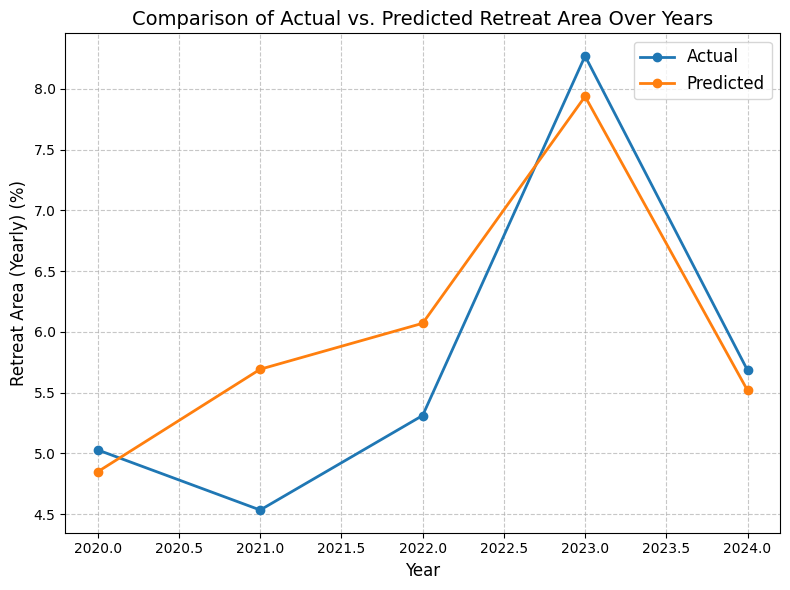

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

csv_path = r"/content/drive/MyDrive/dip_project/unimodal/numerical_model_test_predictions.csv"
df = pd.read_csv(csv_path)

print(df)

plt.figure(figsize=(8, 6))

plt.plot(df["Year"], df["Actual Retreat Area (Yearly) (%)"], label="Actual", marker="o", linewidth=2)
plt.plot(df["Year"], df["Predicted Retreat Area (Yearly) (%)"], label="Predicted", marker="o", linewidth=2)

plt.xlabel("Year", fontsize=12)
plt.ylabel("Retreat Area (Yearly) (%)", fontsize=12)
plt.title("Comparison of Actual vs. Predicted Retreat Area Over Years", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


   Year  Actual Retreat Area (Yearly) (%)  Predicted Retreat Area (Yearly) (%)
0  2020                          5.027771                             4.848312
1  2021                          4.532993                             5.692293
2  2022                          5.311274                             6.070502
3  2023                          8.271158                             7.938245
4  2024                          5.683827                             5.517941


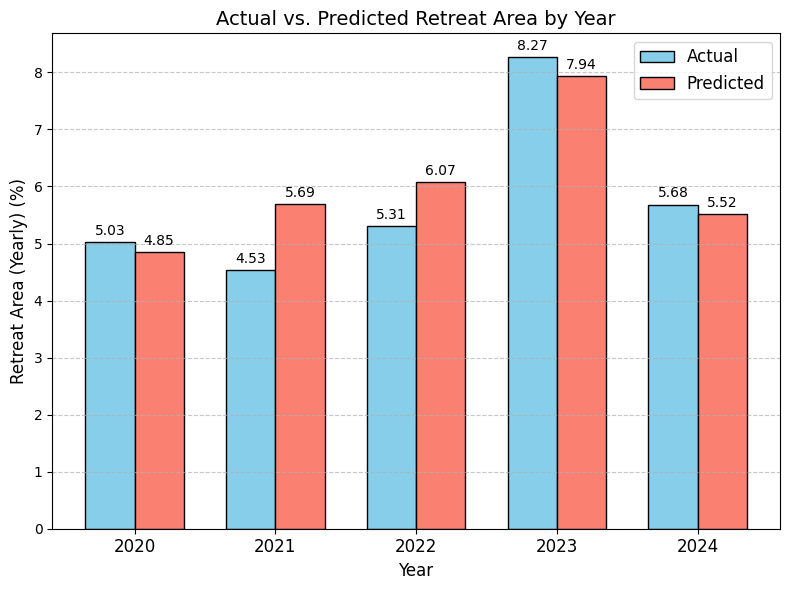

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

csv_path = r"/content/drive/MyDrive/dip_project/unimodal/numerical_model_test_predictions.csv"
df = pd.read_csv(csv_path)
print(df)

years = df["Year"].astype(int)
actual_values = df["Actual Retreat Area (Yearly) (%)"]
predicted_values = df["Predicted Retreat Area (Yearly) (%)"]

x = np.arange(len(years))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))

rects1 = ax.bar(x - width/2, actual_values, width, label='Actual', color='skyblue', edgecolor='black')

rects2 = ax.bar(x + width/2, predicted_values, width, label='Predicted', color='salmon', edgecolor='black')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Retreat Area (Yearly) (%)', fontsize=12)
ax.set_title('Actual vs. Predicted Retreat Area by Year', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(years, fontsize=12)
ax.legend(fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

